# Part 1
## DoWhy example

This exercise is based on [Confounding Example: Finding causal effects from observed data](https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/dowhy_confounder_example.html#Confounding-Example:-Finding-causal-effects-from-observed-data)

Based on the concepts introduced in the previous lecture on estimating causal effects. The first part of the exercise is to use the DoWhy library to estimate causal effects on a dataset. 

In order to evaluate the precision of the estimation we need to simulate the dataset, so we know the true effect. To do this you can either:

1) simulate the dataset yourself based on the SCM principles;
2) use the funtion ```dowhy.datasets.linear_dataset``` to simulate the dataset for you.

When you have the dataset causal effect using DoWhy

### Step 0: Making dataset

/tmp/ipykernel_6468/3488288581.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


   Treatment    Outcome        w0
0   7.445305  14.024902  1.015111
1   9.524016  19.180848  3.615753
2   4.085608   8.402651 -1.881080
3  10.998462  21.310477  4.625390
4   5.844177  12.534261  0.282237


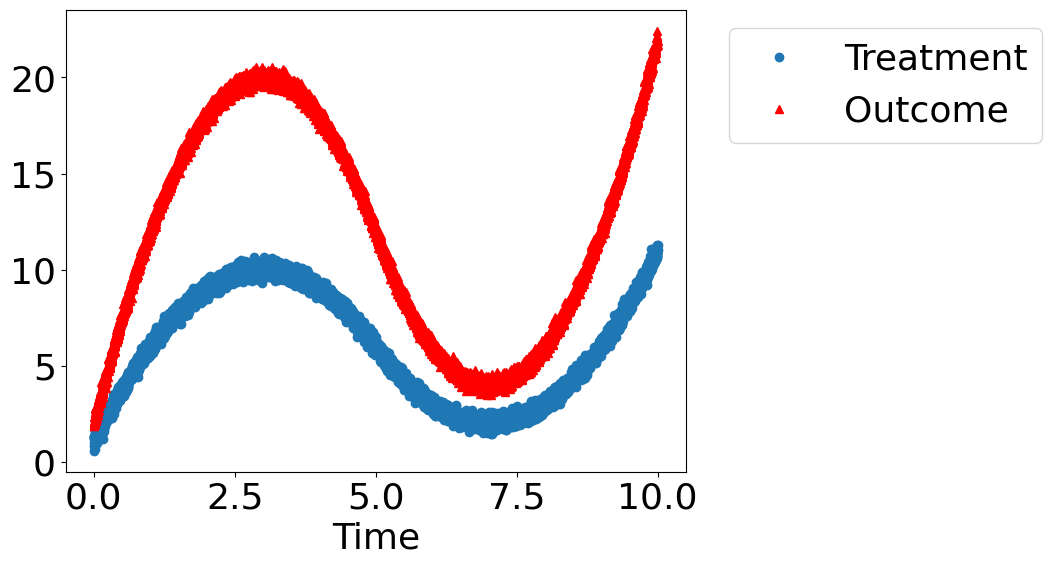

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy
from dowhy import CausalModel
import dowhy.datasets, dowhy.plotter

rvar = 1 if np.random.uniform() >0.5 else 0
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=1,
                                      sd_error=0.2)
df = data_dict['df']
print(df[["Treatment", "Outcome", "w0"]].head())

dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]])

### STEP 1: Model the problem as a causal graph

Once you have a dataset, you need to build the graph that generated the dataset. If you use the DoWhy function it will also generate the graph for you. Once you have the graph remember to plot it! Always make a visualisation if possible. 

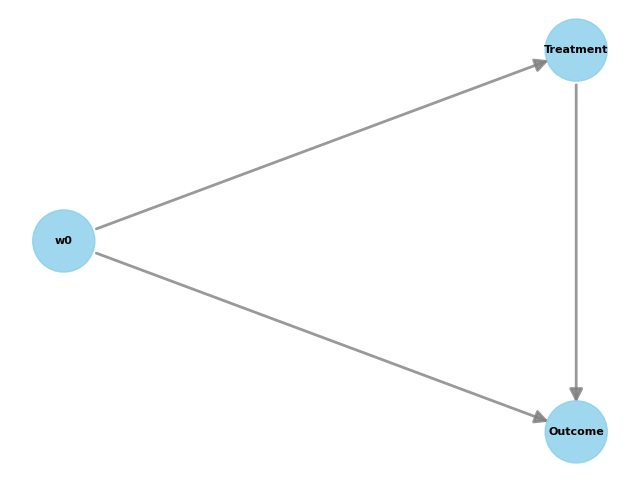

In [3]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
model.view_model()

Showing the causal model stored in the local file “causal_model.png”



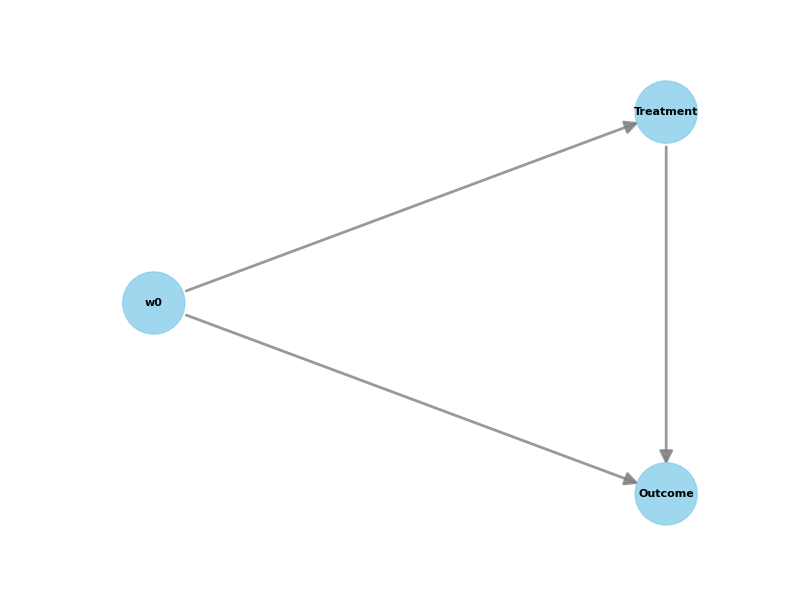

In [4]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### STEP 2: Identify causal effect using properties of the formal causal graph

Once the estimand is identified check it for backdoors, iv (instrumental variables) and frontdoors. If you are happy continue. Pause and consider what would you do if you were not happy with a given estimand?

In [5]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[Outcome|w0])
d[Treatment]               
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,U) = P(Outcome|Treatment,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!




### STEP 3: Estimate the causal effect

Estimate the effect and evaluate it. 

Once we have identified the estimand, we can use any statistical method to estimate the causal effect.

Let’s use Linear Regression for simplicity.

Causal Estimate is: -0.008624859889646785


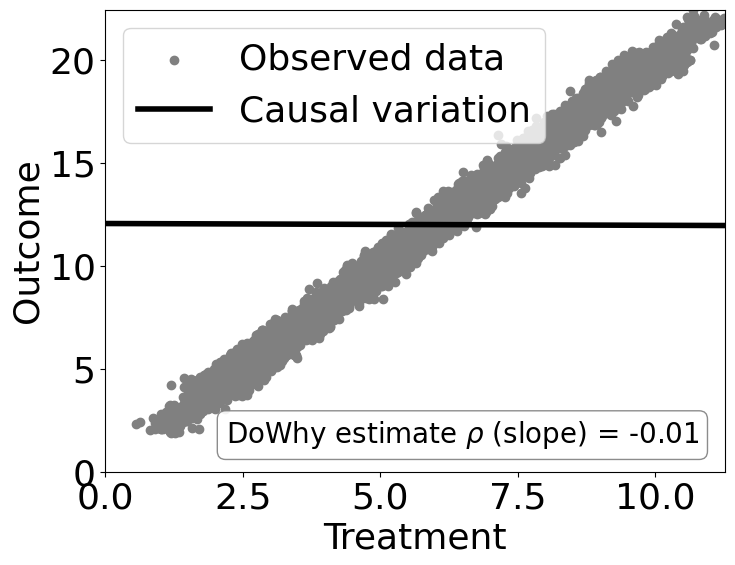

In [6]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(f'Causal Estimate is: {estimate.value}')

# Plot Slope of line between treamtent and outcome =causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

Checking if the estimate is correct:

In [7]:
print("DoWhy estimate is " + str(estimate.value))
print ("Actual true causal effect was {0}".format(rvar))

DoWhy estimate is -0.008624859889646785
Actual true causal effect was 0


### OPTIONAL Step 4: Refuting the estimate

There are several techniques to refute the estimate, in the example link above a few is given. You can try them out and consider what is the reasons for doing them. 

We can also refute the estimate to check its robustness to assumptions (aka sensitivity analysis, but on steroids).

In [8]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning) # removes the warnings from the output

# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(f'Random common cause variablr: {res_random}')

# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(f'Random placebo variable (replaced w. treatment: {res_placebo}')

# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(f'After removing a random subset of the data: {res_subset}')


Random common cause variablr: Refute: Add a random common cause
Estimated effect:-0.008624859889646785
New effect:-0.008636214630102845
p value:0.92

Random placebo variable (replaced w. treatment: Refute: Use a Placebo Treatment
Estimated effect:-0.008624859889646785
New effect:-1.370827375726691e-05
p value:0.98

After removing a random subset of the data: Refute: Use a subset of data
Estimated effect:-0.008624859889646785
New effect:-0.008293828356552594
p value:0.8999999999999999



# Part 2
## Consider how to apply causal inference to your own project.

For your own spend some time considering could causal inference be useful, consider both 
why and why not. 

What sort of questions could causal inference solve in your project?

For causal inference to be useful several things need to be considered: 

- What is the data generating process (DGP)?
- How to graph the DGP?
    - How would you find the information needed to graph it?
    - What is the relation between the different nodes in the graph?
- What is the treatment variable?
- Consider the estimand.
    - Anything that needs to be changed?
- How would you interpret and use any finding? 


